# Using AI to examine the authorship of the Epistles

## Context

Per Wikipedia:
> The Pauline epistles are the fourteen books in the New Testament traditionally attributed to Paul the Apostle, although many dispute the anonymous Epistle to the Hebrews as being a Pauline epistle.[1][2][3]
>
> There is nearly universal consensus in modern New Testament scholarship on a core group of authentic Pauline epistles whose authorship is rarely contested: Romans, 1 and 2 Corinthians, Galatians, Philippians, 1 Thessalonians, and Philemon. Several additional letters bearing Paul's name are disputed among scholars, namely Ephesians, Colossians, 2 Thessalonians, 1 and 2 Timothy, and Titus. Scholarly opinion is sharply divided on whether or not Colossians and 2 Thessalonians are genuine letters of Paul. The remaining four contested epistles – Ephesians, as well as the three known as the Pastoral epistles (1 and 2 Timothy, and Titus) – have been labeled pseudepigraphical works by most critical scholars.[4][5][6] Some scholars have proposed that Paul may have used an amanuensis, or secretary, in writing the disputed letters.[7]
>
> There are two examples of pseudonymous letters written in Paul's name apart from the New Testament epistles, the Epistle to the Laodiceans and 3 Corinthians.
>
> The Epistle to the Hebrews is actually anonymous, but it has been traditionally attributed to Paul. The church father Origen of Alexandria rejected the Pauline authorship of Hebrews, instead asserting that, although the ideas expressed in the letter were genuinely Pauline, the letter itself had actually been written by someone else.[8] Most modern scholars generally agree that Hebrews was not written by the apostle Paul. Various other possible authorships have been suggested.[9]

Source: 

https://en.wikipedia.org/wiki/Authorship_of_the_Pauline_epistles

## Introduction

We'll this space to document the exploration of the above question using a proprietary XLNET-based binary classifier. This isn't intended to be serious research, but could be considered a starting point or template for those curious to pursue this further. Note that the Epistles were originally written in Greek, while the classifier is trained in English. Better results would likely be obtained using a model trained in ancient Greek. 

## Methodology

The source data originates from the KJV Bible corpus found here: https://www.kaggle.com/oswinrh/bible/version/1

An XLNet-based NLP model is trained on a set of Paul's epistles where his authorship is undisputed, as well as a set of epistles where Paul is definitely not the author. The sets will be randomly sampled to prevent biasing the model toward any specific part of the epistle, e.g. greeting, body, or closing.

A validation set composed of different Pauline and non-Pauline texts will be used to establish a baseline for the model's performance. Each verse from the disputed epistles set will then be classified as likely having been written by Paul (authentic, score of 1) or not likely (not authentic, score of 0). 

## Procedure

1. Format source data
2. Create data sets
3. Train binary classifier
4. Analyze predictions

## 1. Format source data

We use a key provided in the dataset's Kaggle page to convert book numbers into names to make things easier for us. We'll also rename the columns to something more understandable.

In [40]:
import pandas as pd

kjv = pd.read_csv('0_source_data/t_kjv.csv')
kjv.rename(columns={
    "field": "id", 
    "field.1": "book", 
    "field.2": "chapter", 
    "field.3": "verse", 
    "field.4": "text",}, inplace=True)

key_df = pd.read_csv('0_source_data/key_english.csv')

books_key = pd.Series(key_df['field.1'].values,index=key_df['field']).to_dict()

kjv['book'] = kjv['book'].map(books_key)
kjv['book'] = kjv['book'].convert_dtypes()
kjv['text'] = kjv['text'].convert_dtypes()

kjv.head()

,id,book,chapter,verse,text
0,1001001,Genesis,1,1,In the beginning God created the heaven and th...
1,1001002,Genesis,1,2,"And the earth was without form, and void; and ..."
2,1001003,Genesis,1,3,"And God said, Let there be light: and there wa..."
3,1001004,Genesis,1,4,"And God saw the light, that it was good: and G..."
4,1001005,Genesis,1,5,"And God called the light Day, and the darkness..."


## 2. Create training and target datasets

The training dataset will be comprised of an equal amount of verses from epistles that are undisputably attributed to Paul and from those that are definitely not from Paul. The target dataset is composed of three different sets of disputed Pauline epistles: Deutero-Pauline, Pastoral, and Sermon. 

In [41]:
# Create training dataset - Authentic
undisputed_paul = kjv.loc[
    (kjv['book'] == 'Romans') |
    (kjv['book'] == '1 Corinthians') | 
    (kjv['book'] == '2 Corinthians') |   
    (kjv['book'] == 'Galatians') |
    (kjv['book'] == 'Philippians') | 
    (kjv['book'] == '1 Thessalonians') | 
    (kjv['book'] == 'Philemon')  
]

undisputed_paul_sample_1 = undisputed_paul.sample(n=250, random_state=1)
undisputed_paul_sample_2 = undisputed_paul.sample(n=250, random_state=2)
undisputed_paul_sample_3 = undisputed_paul.sample(n=250, random_state=3)

undisputed_paul_sample_1['authentic'] = True
undisputed_paul_sample_2['authentic'] = True
undisputed_paul_sample_3['authentic'] = True

# undisputed_paul_sample_1.to_csv('training_data/undisputed_paul_sample_1.csv', index=False)
# undisputed_paul_sample_2.to_csv("training_data/undisputed_paul_sample_2.csv", index=False)
# undisputed_paul_sample_3.to_csv("training_data/undisputed_paul_sample_3.csv", index=False)

print('Created dataset - Authentic')

Created dataset - Authentic


In [42]:
# Create training dataset - Not Authentic
undisputed_catholic = kjv.loc[
    (kjv['book'] == 'James') | 
    (kjv['book'] == '1 Peter') |
    (kjv['book'] == '2 Peter') | 
    (kjv['book'] == '1 John') |
    (kjv['book'] == '2 John') | 
    (kjv['book'] == '3 John') | 
    (kjv['book'] == 'Jude')
]

undisputed_catholic_sample_1 = undisputed_catholic.sample(n=250, random_state=1)
undisputed_catholic_sample_2 = undisputed_catholic.sample(n=250, random_state=2)
undisputed_catholic_sample_3 = undisputed_catholic.sample(n=250, random_state=3)

undisputed_catholic_sample_1['authentic'] = False
undisputed_catholic_sample_2['authentic'] = False
undisputed_catholic_sample_3['authentic'] = False

# undisputed_catholic_sample_1.to_csv("training_data/undisputed_catholic_sample_1.csv", index=False)
# undisputed_catholic_sample_2.to_csv("training_data/undisputed_catholic_sample_2.csv", index=False)
# undisputed_catholic_sample_3.to_csv("training_data/undisputed_catholic_sample_3.csv", index=False)

print('Created datasets - Not Authentic')

Created datasets - Not Authentic


In [43]:
# Create validation sets
undisputed_paul_ids = pd.concat([
    undisputed_paul_sample_1['id'],
    undisputed_paul_sample_2['id'],
    undisputed_paul_sample_3['id']
], ignore_index=True)

undisputed_catholic_ids = pd.concat([
    undisputed_catholic_sample_1['id'],
    undisputed_catholic_sample_2['id'],
    undisputed_catholic_sample_3['id']
], ignore_index=True)

validation_paul = undisputed_paul[~undisputed_paul['id'].isin(undisputed_paul_ids)]
validation_catholic = undisputed_catholic[~undisputed_catholic['id'].isin(undisputed_catholic_ids)]

# validation_paul.to_csv('validation_data/validation_paul', index=False)
# validation_catholic.to_csv('validation_data/validation_catholic', index=False)

print('Created datasets - Validation')

Created datasets - Validation


In [44]:
# Create target datasets
disputed_deuteropauline = kjv.loc[
    (kjv['book'] == 'Ephesians') | 
    (kjv['book'] == 'Colossians') |
    (kjv['book'] == '2 Thessalonians')
]

disputed_pastoral = kjv.loc[
    (kjv['book'] == '1 Timothy') | 
    (kjv['book'] == '2 Timothy') |
    (kjv['book'] == 'Titus') 
]

disputed_sermon = kjv.loc[
    (kjv['book'] == 'Hebrews')
]

print('Created dataset - Target')

Created dataset - Target


## 3. Train model

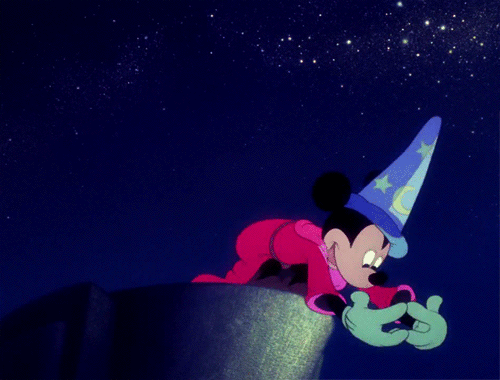

This part is done in Primer Automate. We upload the training datasets and find that we obtain a "Good" model rating from the platform. To verify that, we'll test the model on a validation set before proceeding with the target dataset.

## 4. Analyze predictions

### Validation set

In [45]:
### Analyze validation set
validated_p = pd.read_csv("4_validation_results/validation_paul.csv")
validated_c = pd.read_csv("4_validation_results/validation_catholic.csv")

mean_p = validated_p['authentic'].mean()
mean_c = validated_c['authentic'].mean()


median_p = validated_p['authentic'].median()
median_c = validated_c['authentic'].median()

std_p = validated_p['authentic'].std()
std_c = validated_c['authentic'].std()

print('')
print('                             Mean                   Median                 Standard Dev.')
print('----------------------------------------------------------------------------------------------')
print(f'Validated Paul         {mean_p}      {median_p}        {std_p}')
print(f'Validated Not Paul     {mean_c}      {median_c}      {std_c}')
print('')


                             Mean                   Median                 Standard Dev.
----------------------------------------------------------------------------------------------
Validated Paul         0.8115804321322304      0.986222684383392        0.31231205103198084
Validated Not Paul     0.2979731111379806      0.09138147905468949      0.34483631625130623



In [46]:
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

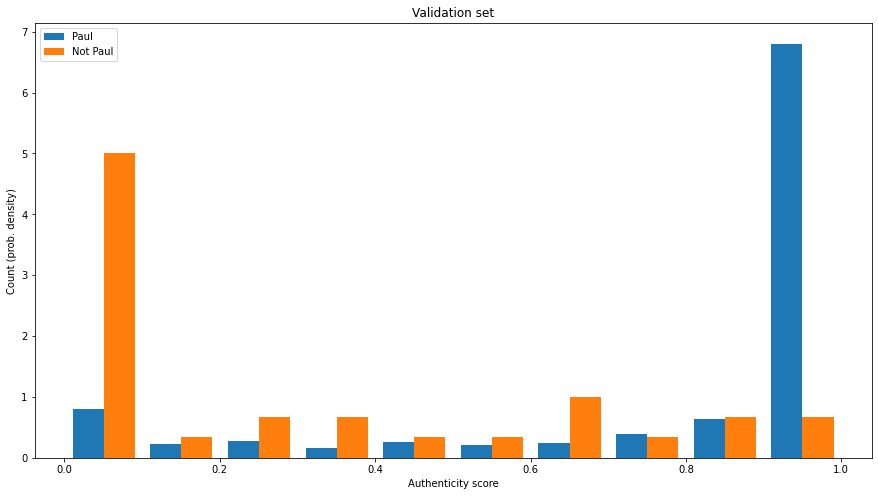

In [47]:
fig, ((ax0)) = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
labels = ['Paul', 'Not Paul']
ax0.hist([validated_p['authentic'],validated_c['authentic']], 10, histtype='bar', density=1,label=labels)
ax0.legend(prop={'size': 10})
ax0.set_title('Validation set')
ax0.set_xlabel("Authenticity score")
ax0.set_ylabel("Count (prob. density)")
plt.show()

### Target dataset

In [48]:
### Analyze results
result_dp = pd.read_csv("6_results/results_disputed_deuteropauline.csv")
result_p = pd.read_csv("6_results/results_disputed_pastoral.csv")
result_s = pd.read_csv("6_results/results_disputed_sermon.csv")

mean_dp = result_dp['authentic'].mean()
mean_p = result_p['authentic'].mean()
mean_s = result_s['authentic'].mean()

median_dp = result_dp['authentic'].median()
median_p = result_p['authentic'].median()
median_s = result_s['authentic'].median()

std_dp = result_dp['authentic'].std()
std_p = result_p['authentic'].std()
std_s = result_s['authentic'].std()


print('')
print('                           Mean                   Median                 Standard Dev.')
print('----------------------------------------------------------------------------------------------')
print(f'Deutero-Pauline     {mean_dp}       {median_dp}         {std_dp}')
print(f'Pastoral            {mean_p}      {median_p}       {std_p}')
print(f'Hebrews             {mean_s}       {median_s}        {std_s} ')
print('')


                           Mean                   Median                 Standard Dev.
----------------------------------------------------------------------------------------------
Deutero-Pauline     0.5634406825661015       0.72352409362793         0.4204711378047253
Pastoral            0.48911413083729444      0.4758843779563905       0.4206532232557766
Hebrews             0.5844187914524858       0.732964992523193        0.40337362026125184 



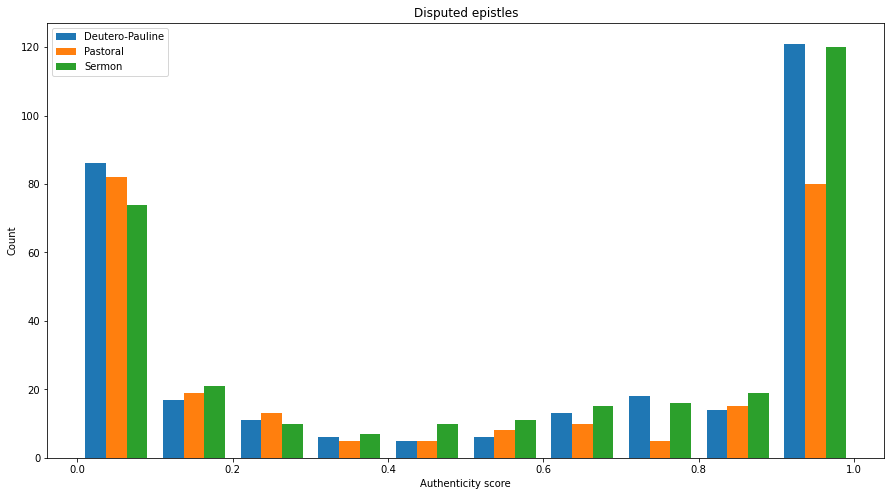

In [49]:
fig, ((ax0)) = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
labels = ['Deutero-Pauline', 'Pastoral', 'Sermon']
ax0.hist([result_dp['authentic'],result_p['authentic'],result_s['authentic']], 10, histtype='bar', label=labels)
ax0.legend(prop={'size': 10})
ax0.set_title('Disputed epistles')
ax0.set_xlabel("Authenticity score")
ax0.set_ylabel("Count")
plt.show()

## Observations

The authenticity distribution for the disputed epistles tracks that of the validation set. This suggests that Paul wasn't the only author of the disputed epistles. 

To determine which chapters and books were likely written by Paul, we'll average the authenticity scores at the chapter and book levels. 

A caveat is that these results are based on the KJV translation of original Greek texts. Additional insights could surface using an ancient Greek-trained XLNet model on the original Greek epistles. 

In [50]:
# Retrieve metadata the model dropped and remove columns the model inserted
final_dp = result_dp.set_index('document_id').join(disputed_deuteropauline.set_index('id'))
final_dp = final_dp.drop(columns=['document_title','document_date','document_text'])

final_p = result_p.set_index('document_id').join(disputed_pastoral.set_index('id'))
final_p = final_p.drop(columns=['document_title','document_date','document_text'])

final_s = result_s.set_index('document_id').join(disputed_sermon.set_index('id'))
final_s = final_s.drop(columns=['document_title','document_date','document_text'])

In [51]:
print('Deutero-Pauline')
print('---------------')
print(final_dp.groupby('book')['authentic'].mean())
print('\nPastoral')
print('--------')
print(final_p.groupby('book')['authentic'].mean())
print('\nSermon')
print('------')
print(final_s.groupby('book')['authentic'].mean())

Deutero-Pauline
---------------
book
2 Thessalonians    0.595138
Colossians         0.527484
Ephesians          0.575867
Name: authentic, dtype: float64

Pastoral
--------
book
1 Timothy    0.513008
2 Timothy    0.562470
Titus        0.298059
Name: authentic, dtype: float64

Sermon
------
book
Hebrews    0.584419
Name: authentic, dtype: float64


In [52]:
print('Deutero-Pauline')
print('---------------')
print(final_dp.groupby(['book','chapter'])['authentic'].mean())
print('\nPastoral')
print('--------')
print(final_p.groupby(['book','chapter'])['authentic'].mean())
print('\nSermon')
print('------')
print(final_s.groupby(['book','chapter'])['authentic'].mean())

Deutero-Pauline
---------------
book             chapter
2 Thessalonians  1          0.453454
                 2          0.407280
                 3          0.867017
Colossians       1          0.552533
                 2          0.645203
                 3          0.394533
                 4          0.521364
Ephesians        1          0.557457
                 2          0.661826
                 3          0.809594
                 4          0.445806
                 5          0.579558
                 6          0.478542
Name: authentic, dtype: float64

Pastoral
--------
book       chapter
1 Timothy  1          0.645886
           2          0.700250
           3          0.509551
           4          0.383307
           5          0.504118
           6          0.364751
2 Timothy  1          0.556767
           2          0.509741
           3          0.512653
           4          0.667946
Titus      1          0.232531
           2          0.246806
           3        